<a href="https://colab.research.google.com/github/eunseochu/OB_4th/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EB%B9%84%EC%A7%80%EB%8F%84%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CHAPTER 9: 비지도 학습**

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import warnings

warnings.filterwarnings(action='ignore') 

## **9.1 군집**

#### **1) 군집이란?**
비슷한 샘플을 구별해 하나의 클러스터 또는 비슷한 샘플의 그룹으로 할당하는 작업
- 분류와 마찬가지로 각 샘플을 하나의 그룹에 할당하지만, 분류와 달리 **비지도 학습**
- 레이블이 되어 있지 않아 분류 알고리즘을 사용할 수 없는 경우 사용
- 모든 특성을 사용하면 군집 알고리즘이 클러스터를 매우 잘 구분할 수 있음

#### **2) 군집이 사용되는 애플리케이션**

**2-1) 고객 분류** <br/>
**고객을 구매 이력이나 웹사이트 내 행동 등을 기반으로 클러스터**를 모을 수 있음
- 고객이 누구인지, 고객이 무엇을 원하는지 이해하는 데 도움이 됨
- 고객 그룹마다 제품 추천이나 마케팅 전략을 다르게 적용할 수 있음
  - ex. 동일한 클러스터 내의 사용자가 좋아하는 콘텐츠를 추천하는 추천 시스템

**2-2) 데이터 분석** <br/>
새로운 데이터셋을 분석할 때 군집 알고리즘을 실행하고 **각 클러스터를 따로 분석**하면 도움이 됨

**2-3) 차원 축소 기법** <br/>
한 데이터셋에 군집 알고리즘을 적용하면 각 클러스터에 대한 샘플의 친화성을 측정 가능
- **친화성은 샘플이 클러스터에 얼마나 잘 맞는지**를 측정
- 각 샘플의 특성 벡터 x는 클러스터 친화성의 벡터로 바꿀 수 있음
  - k개의 클러스터가 있다면 이 벡터는 K차원이 됨
  - 일반적으로 원본 특성 벡터보다 훨씬 저차원이지만, 분석을 위한 충분한 정보를 가짐

**2-4) 이상치 탐지** <br/>
모든 클러스터에 친화성이 낮은 샘플은 이상치일 가능성이 높음
- 웹사이트 내 행동을 기반으로 사용자의 클러스터를 만들었다면 <br/> 초당 웹서버 요청을 비정상적으로 많이 하는 사용자를 감지할 수 있음 
- 제조 분야에서 결함을 감지할 때 유용하며, 부정 거래 감지에도 활용됨

**2-5) 준지도 학습** <br/>
레이블된 샘플이 적다면 군집을 수행하고 **동일한 클러스터에 있는 모든 샘플에 레이블을 전파**할 수 있음
- 지도 학습 알고리즘에 필요한 레이블이 크게 증가해 성능을 크게 향상

**2-6) 검색 엔진** <br/>
일부 검색 엔진은 제시된 이미지와 비슷한 이미지를 찾아주며, <br/> 시스템을 구축하려면 먼저 데이터 베이스에 있는 모든 이미지에 군집 알고리즘 적용
- 비슷한 이미지는 동일한 클러스터에 속함
- 사용자가 찾으려는 이미지를 제공하면 훈련된 군집 모델을 사용해 이미지의 클러스터를 찾음
- 이후 클러스터의 모든 이미지를 반환

**2-7) 이미지 분할** <br/>
색을 기반으로 픽셀을 클러스터로 모은 후 각 픽셀의 색을 해당 클러스터의 평균 색으로 바꿈
- 이미지에 있는 색상의 종류를 크게 줄임
- 물체의 윤곽을 감지하기 쉬워져 물체 탐지 및 추적 시스템에서 많이 활용

#### **3) 클러스터 알고리즘**
클러스터에 대한 보편적인 정의는 없으며, 알고리즘이 다르면 다른 종류의 클러스터를 감지함
- 센트로이드라 부르는 특정 포인트를 중심으로 모인 샘플을 찾는 알고리즘
- 샘플이 밀집되어 연속된 영역을 찾는 알고리즘
- 어던 모양이든 될 수 있는 알고리즘
- 계층적으로 클러스터의 클러스터를 찾는 알고리즘 등

### **9.1.1 K-평균**
반복 몇 번으로 레이블이 없는 데이터셋을 빠르고 효율적으로 클러스터로 묶을 수 있는 간단한 알고리즘

#### **1) K-평균 알고리즘 훈련**
각 클러스터의 중심을 찾고 가장 가까운 클러스터에 샘플을 할당하는 알고리즘

In [3]:
# 예제 데이터
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

**1-1) 클러스터 개수 𝒌 지정** <br/>
알고리즘이 찾을 클러스터 개수 𝒌를 지정해야 하며, 일반적으로 쉬운 일이 아님
- 각 샘플은 **𝒌개의 클러스터 중 하나에 할당** 됨
- 군집에서 각 샘플의 레이블은 알고리즘이 샘플에 할당한 클러스터의 인덱스
  - 군집은 비지도 학습이기 때문에, 분류에서의 클래스 레이블과 다름

In [4]:
from sklearn.cluster import KMeans

In [5]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

**1-2) KMeans 클래스의 인스턴스** <br/>
labels_ 인스턴트 변수에 훈련된 샘플의 레이블을 가짐

In [6]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [7]:
y_pred is kmeans.labels_

True

**1-3) 센트로이드 확인** <br/>
알고리즘이 찾은 센트로이드(클러스터의 중심)를 확인할 수 있음

In [8]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

**1-4) 새로운 샘플에 클러스터 할당** <br/>
새로운 샘플에 가장 가까운 센트로이드의 클러스터를 할당할 수 있음

In [9]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

**1-5) 보로노이 다이어그램** <br/>
클러스터의 결정 경계를 그려보면 보로노이 다이어그램을 얻을 수 있음
- 센트로이드는 X로 표시되어 있음

In [10]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12, 
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

그림 저장: voronoi_plot


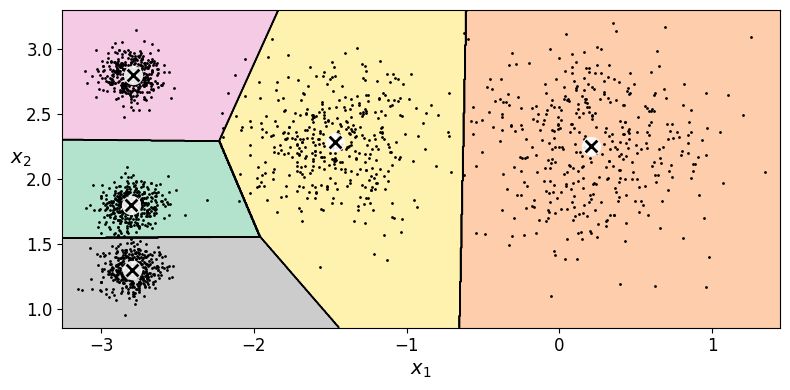

In [11]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

- 샘플은 대부분 적절한 클러스터에 잘 할당 됨
- 왼쪽 위에 있는 클러스터와 가운데 클러스터의 경계 부근은 레이블이 잘못 부여됨
  - k-평균 알고리즘은 **클러스터의 크기가 많이 다르면 잘 작동하지 않음**
  - 샘플을 클러스터에 할당할 때 센트로이드까지 거리를 고려하는 것이 전부이기 때문

#### **2) 하드 군집과 소프트 군집**
하드 군집보다 소프트 군집이 더 유용하게 사용될 수 있음
- **하드 군집**: 샘플을 하나의 클러스터에 할당하는 것
- **소프트 군집**: 클러스터마다 **샘플에 점수를 부여**하는 것
  - 샘플과 센트로이드 사이의 거리나 가우시안 방사 기저 함수와 같은 유사도 점수(친화성 점수)
  - KMeans 클래스의 transform() 메서드는 샘플과 각 센트로이드 사이의 거리를 반환

In [12]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

- X_new에 있는 첫 번째 샘플이 첫 번째 센트로이드에 2.81, 두 번째 센트로이드에서 0.33, <br/> 세 번째 센트로이드에서 2.90, 네 번째 센트로이드에서 1.49, 다섯 번째 센트로이드에서 2.89 거리만큼 떨어져 있음
  - 고차원 데이터셋을 이런 방식으로 변환하면 𝒌-차원 데이터셋이 만들어 짐
  - 이 변환은 매우 효율적인 비선형 차원 축소 기법이 될 수 있음 

#### **3) k-평균 알고리즘**

**3-1) 센트로이드이나 레이블이 주어지는 경우** <br/>
- 센트로이드가 주어진다면, 데이터셋에 있는 모든 샘플에 가장 가까운 센트로이드의 클러스터를 할당
- 모든 샘플의 레이블이 주어진다면, 각 클러스터에 속한 샘플의 평균을 계산하여 모든 센트로이드를 구함

**3-2) 센트로이드나 레이블이 주어지지 않는 경우** <br/>
- 센트로이드를 랜덤하게 선정(초기화)
  - 예를 들어 무작위로 𝒌개의 샘플을 뽑아 그 위치를 센트로이드로 설정
- 샘플에 레이블을 할당하고 센트로이드를 업데이트하는 것을 반복
- 이 과정을 센트로이드에 변화가 없을 때까지 진행
  - 제한된 횟수 안에 수렴하는 것을 보장함
  - 일반적으로 이 횟수는 매우 작으며, 무한하게 반복되지 않음
  - 샘플과 가장 가까운 센트로이드 사이의 평균 제곱 거리가 매 단계마다 작아질 수밖에 없기 때문 

In [13]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

그림 저장: kmeans_algorithm_plot


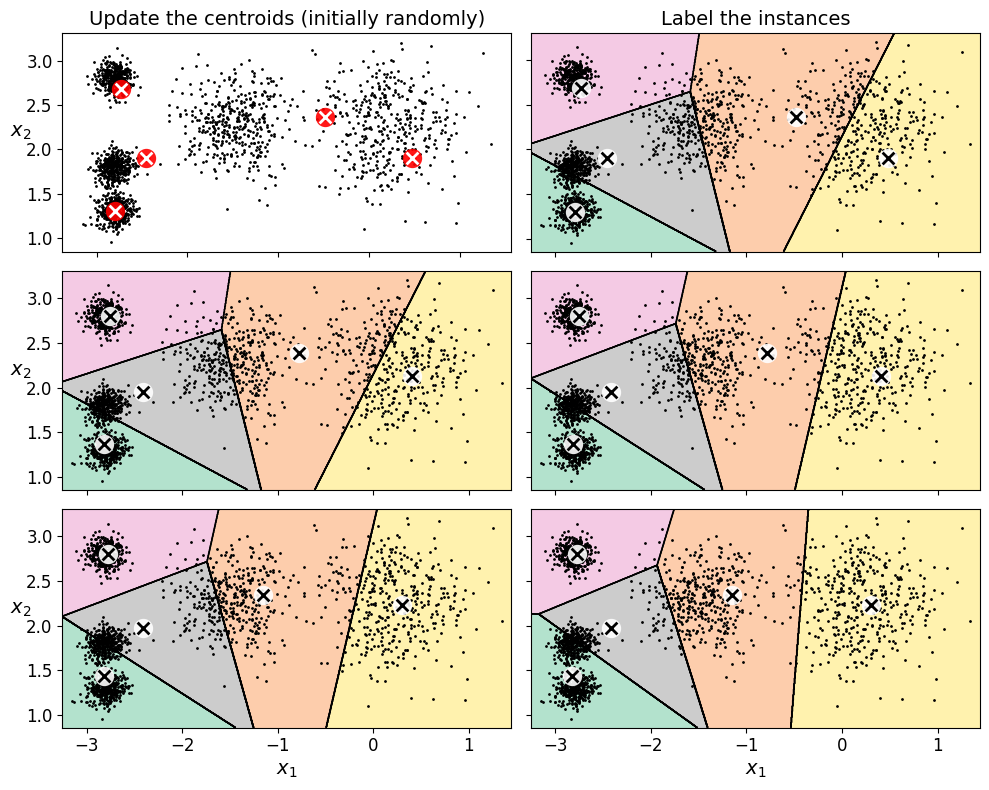

In [14]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

**3-3) 최적이 아닌 솔루션의 예시** <br/>
k-평균 알고리즘은 수렴하는 것이 보장되지만, 적절한 솔루션으로 수렴하지 못할 수도 있음
- **센트로이드 초기화**에 따라 지역의 최적점으로 수렴하는 경우가 발생
- 센트로이드 초기화를 개선하면 이런 위험을 줄일 수 있음

In [15]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

그림 저장: kmeans_variability_plot


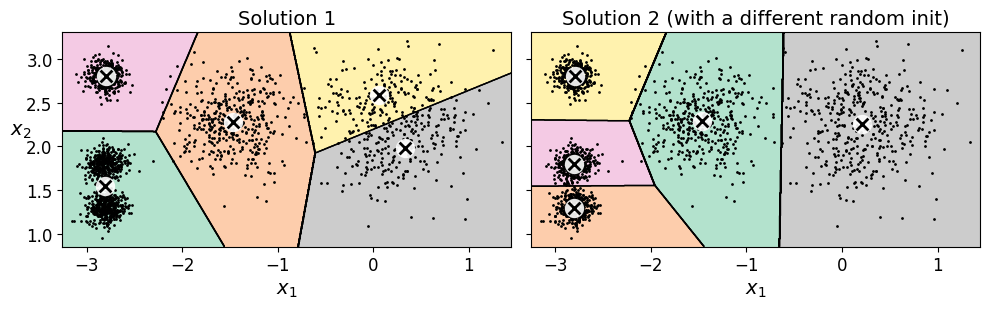

In [16]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

#### **4) 센트로이드 초기화 방법**

**4-1) 센트로이드 위치를 근사하게 알 수 있는 경우** <br/>
init 매개변수에 센트로이드 리스트를 담은 넘파이 배열을 지정하고 n_init을 1로 설정할 수 있음
- ex. 또 다른 군집 알고리즘을 먼저 실행할 수 있는 경우

**4-2) 센트로이드 초기화를 하는 또 다른 방법** <br/>
랜덤 초기화를 다르게 하여 여러 번 알고리즘을 실행하고 가장 좋은 솔루션을 선택하는 것
- 랜덤 초기화 횟수는 n_init 매개변수로 조절
  - n_init의 기본 값은 10
  - fit() 메서드를 호출할 때 앞서 설명한 전체 알고리즘이 10번 실행된다는 뜻
- 사이킷런은 이 중에 최선의 솔루션을 반환함

**4-3) 모델의 이너셔** <br/>
각 샘플과 가장 가까운 센트로이드 사이의 평균 제곱 거리
- 최선의 솔루션을 알아내기 위한 성능 지표로 사용
- KMeans 클래스는 알고리즘을 n_init번 실행하여 **이너셔가 가장 낮은 모델 반환**
- intertia_ 인스턴스 변수로 모델의 이너셔 확인 가능

In [17]:
kmeans.inertia_

211.5985372581684

**4-4) score() 메서드** <br/>
score() 메서드는 이너셔의 음숫값을 반환
- 예측기의 score() 메서드는 사이킷런의 '**큰 값이 좋은 것이다**'라는 규칙을 따라야하기 때문
- 한 예측기가 다른 것보다 좋다면 score() 메서드가 더 높은 값을 반환해야 함

In [18]:
kmeans.score(X)

-211.59853725816836

#### **5) k-평균++ 알고리즘**
다른 센트로이드와 거리가 먼 센트로이드를 선택하는 똑똑한 초기화 단계를 갖춘 K-평균 알고리즘
- k-평균 알고리즘이 최적이 아닌 솔루션으로 수렴할 가능성을 크게 낮춤
- 최적의 솔루션을 찾기 위해 실행할 알고리즘 반복 횟수를 크게 줄일 수 있기 때문에, 추가 계산에 충분한 가치 존재

**5-1) k-평균++ 초기화 알고리즘** <br/>
- 데이터셋에서 무작위로 균등하게 하나의 센트로이드 𝒆1 선택
- 𝑫(𝒙𝒊)^2/𝜮𝑫(𝒙𝒋)^2의 확률로 샘플 𝒙𝒊를 새로운 센트로이드 𝒆𝒊로 선택
  - 𝑫(𝒙𝒊)는 샘플 𝒙𝒊와 이미 선택된 가장 가까운 센트로이드까지 거리
  - 이 확률 분포는 이미 선택된 센트로이드에서 멀리 떨어진 샘플을 다음 센트로이드로 선택할 가능성을 높임
- 𝒌개의 센트로이드가 선택될 때까지 이전 단계를 반복

**5-2) KMeans 클래스 초기화 방법** <br/>
KMeans 클래스는 기본적으로 k-평균++ 초기화 알고리즘을 사용
- 원래 방식(즉, 𝒌개의 샘플을 랜덤하게 선택하여 초기 센트로이드로 지정)은 init 매개변수를 "random"으로 지정
- 그러나, 기존의 방식을 사용할 필요성은 거의 없음

#### **6) k-평균 속도 개선과 미니배치 k-평균**

**6-1) k-평균 속도 개선** <br/>
불필요한 거리 계산을 많이 피함으로서 알고리즘의 속도를 상당히 높임
- 삼각 부등식(AC <= AB + BC)을 사용하는 방식
  - 두 점의 직선은 항상 가장 짧은 거리가 됨
  - 샘플과 센트로이드 사이의 거리를 위한 하한선과 상한선을 유지
- KMeans 클래스에서 기본으로 사용하는 알고리즘
  - 원래 알고리즘을 사용하려면 algorithm 매개변수를 "full"로 지정
  - 그러나, 기존의 알고리즘을 사용할 필요성은 거의 없음

**6-2) 미니배치 k-평균 알고리즘** <br/>
전체 데이터셋을 사용해 반복하지 않고 각 반복마다 미니배치를 사용해 센트로이드를 조금씩 이동
- 알고리즘의 속도를 3배에서 4배 정도 높임
- 메모리에 들어가지 않는 대량의 데이터셋에 군집 알고리즘을 적용할 수 있음
- MiniBatchKMeans 클래스에 알고리즘이 구현되어있으며, KMeans 클래스처럼 사용 가능

In [19]:
from sklearn.cluster import MiniBatchKMeans

In [20]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

**6-3) 데이터셋이 메모리에 들어가지 않는 경우** <br/>
- 점진적 PCA에서 했던 것처럼 meamp 클래스를 사용
- MiniBatchKMeans 클래스의 partial_fit() 메서드에 한 번에 하나의 미니배치를 전달
- 초기화를 여러 번 수행하고 만들어진 결과에서 가장 좋을 것을 직접 골라야 해 해야할 일이 많음

**6-4) 미니배치 k-평균 알고리즘 vs 일반 K-평균 알고리즘** <br/>
미니배치 k-평균 알고리즘이 일반 K-평균 알고리즘보다 훨씬 빠름
- 이너셔는 일반적으로 조금 더 나쁘며, 특히 클러스터의 개수가 증가할 때 그런 경향을 보임

In [21]:
from timeit import timeit

In [22]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

그림 저장: minibatch_kmeans_vs_kmeans


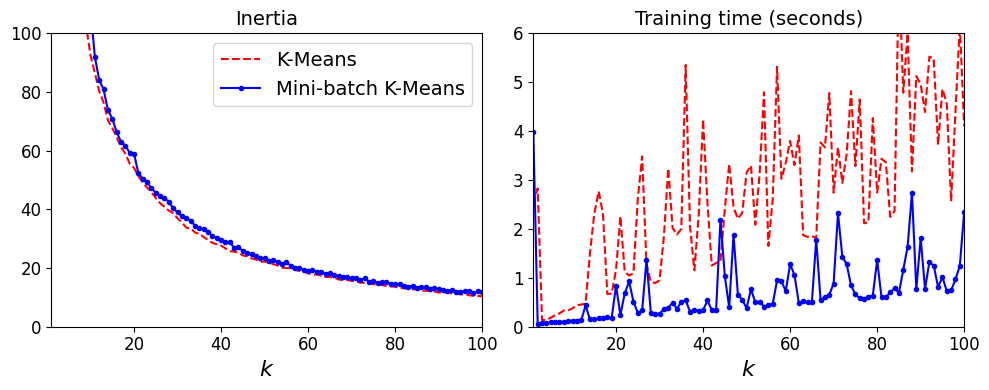

In [23]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

- 여러 가지 클러스터 개수 𝒌를 사용해 미니배치 k-평균과 일반 k-평균 모델의 이너셔 비교
- 두 곡선의 차이는 상당히 일정하게 유지됨
  - 𝒌가 증가함에 따라 이너셔가 점점 줄어들기 때문에 두 곡선의 차이가 차지하는 비율이 점ㅈ머 커짐
  - 미니배치 k-평균이 일반 k-평균보다 훨씬 빠르고 𝒌가 증가함에 따라 더 커짐

#### **7) 최적의 클러스터 개수 찾기**
일반적으로 클러스터 개수 𝒌를 어떻게 설정할지 쉽게 알 수 없으며, 올바르게 지정하지 않으면 결과가 나빠짐

**7-1) 잘못된 클러스터 개수 선택** <br/>
𝒌가 너무 작으면 별개의 클러스터를 합치고, 𝒌가 너무 크면 하나의 클러스터가 여러 개로 나뉨

그림 저장: bad_n_clusters_plot


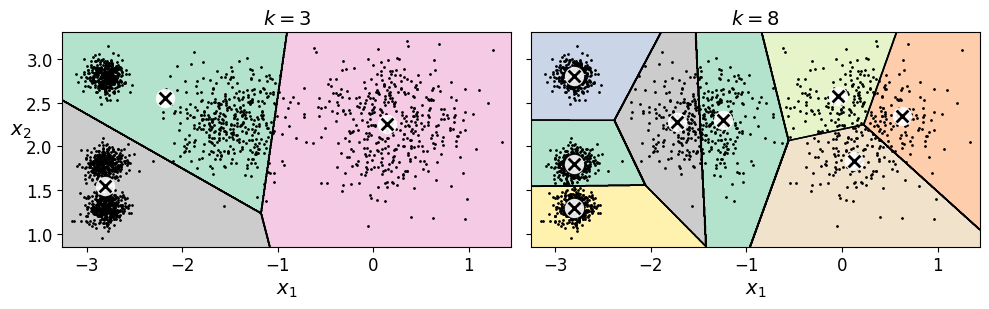

In [24]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

**7-2) 이너셔로 클러스터 개수 선택** <br/>
이너셔는 𝒌가 증가함에 따라 점점 작아지므로 𝒌를 선택할 때 좋은 지표가 아님
- 클러스터가 늘어날수록 각 샘플은 가까운 센트로이드에 더 가까워짐
- 자연스럽게 이너셔는 작아질 것이므로 가장 작은 이너셔를 선택하는 것은 바람직하지 않음

In [25]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

그림 저장: inertia_vs_k_plot


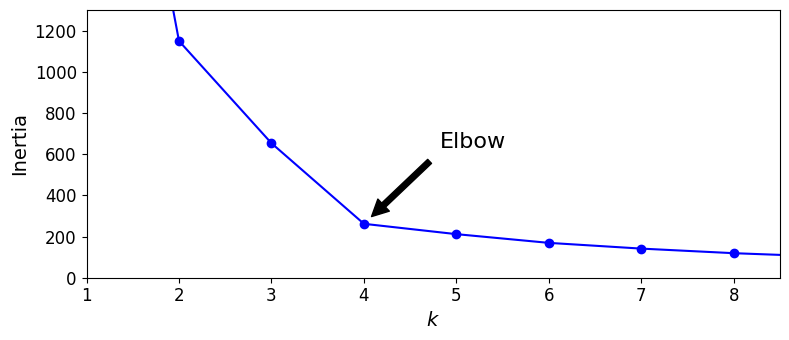

In [26]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

- 이너셔는 𝒌가 4까지 증가할 때 빠르게 줄어들지만, 𝒌가 계속 증가하면 훨씬 느리게 감소
  - 이너셔 그래프를 클러스터 개수 𝒌의 함수로 그렸을 때 그래프가 꺾이는 지점을 엘보라고 부름
  - 𝒌=4 지점이 엘보이며, 𝒌에 대한 정답을 모른다면 엘보는 좋은 선택이 됨
  - 이보다 작은 값은 변화가 심하고 더 큰 값은 크게 도움이 되지 않음

**7-3) 실루엣 점수** <br/>
모든 샘플에 대한 **실루엣 계수 (b-a)/max(a,b) 의 평균**
- **a는 동일한 클러스터에 있는 다른 샘플까지의 평균 거리**
  - 클러스터 내부의 평균 거리
- **b는 가장 가까운 클러스터까지의 평균 거리**
  - 가장 가까운 클러스터의 샘플까지의 평균 거리
  - 샘플과 가장 가까운 클러스터는 자신이 속한 클러스터는 제외하고 b가 최소인 클러스터
- 실루엣 계수는 **-1에서 +1까지** 바뀔 수 있음
  - **+1에 가까우면 자신의 클러스터 안에 잘 속해있고 다른 클러스터와는 멀리 떨어져 있다는 뜻**
  - 0에 가까우면 클러스터 경계에 위치한다는 의미
  - -1에 가까우면 샘플이 잘못된 클러스터에 할당되었다는 의미
- 사이킷런의 **silhouette_score()** 함수를 사용해 계산
  - 이너셔로 선택하는 방법보다 정확하지만 계산 비용이 많이 드는 방법
  - 데이터셋에 있는 모든 샘플과 할당된 레이블을 전달

In [27]:
from sklearn.metrics import silhouette_score

In [28]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [29]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

그림 저장: silhouette_score_vs_k_plot


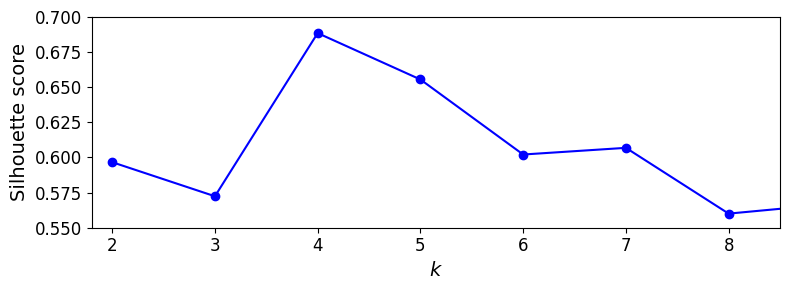

In [30]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

- 클러스터 개수를 달리해 실루엣 점수를 비교해봤을 때, 이전보다 많은 정보를 얻을 수 있음
  - 𝒌=4가 좋은 선택이지만 𝒌=5도 꽤 좋으며 𝒌=6이나 7보다 훨씬 좋음
  - 이너셔를 비교했을 때는 드러나지 않음

**7-4) 실루엣 다이어그램** <br/>
모든 샘플의 실루엣 계수를 할당된 클러스터와 계숫값으로 정렬한 그래프
- 클러스터마다 칼 모양의 그래프가 그려짐
- **높이는 클러스터가 포함하고 있는 샘플의 개수**
- **너비는 클러스터에 포함된 샘플의 정렬된 실루엣 계수**
  - 너비가 넓을수록 좋음
- **수직 파선은 각 클러스터 개수에 해당하는 실루엣 점수**
  - 한 클러스터의 샘플 대부분이 이 점수보다 낮은 계수를 가지면 나쁜 클러스터
  - 클러스터의 샘플이 다른 클러스터와 너무 가깝다는 것을 의미하기 때문

그림 저장: silhouette_analysis_plot


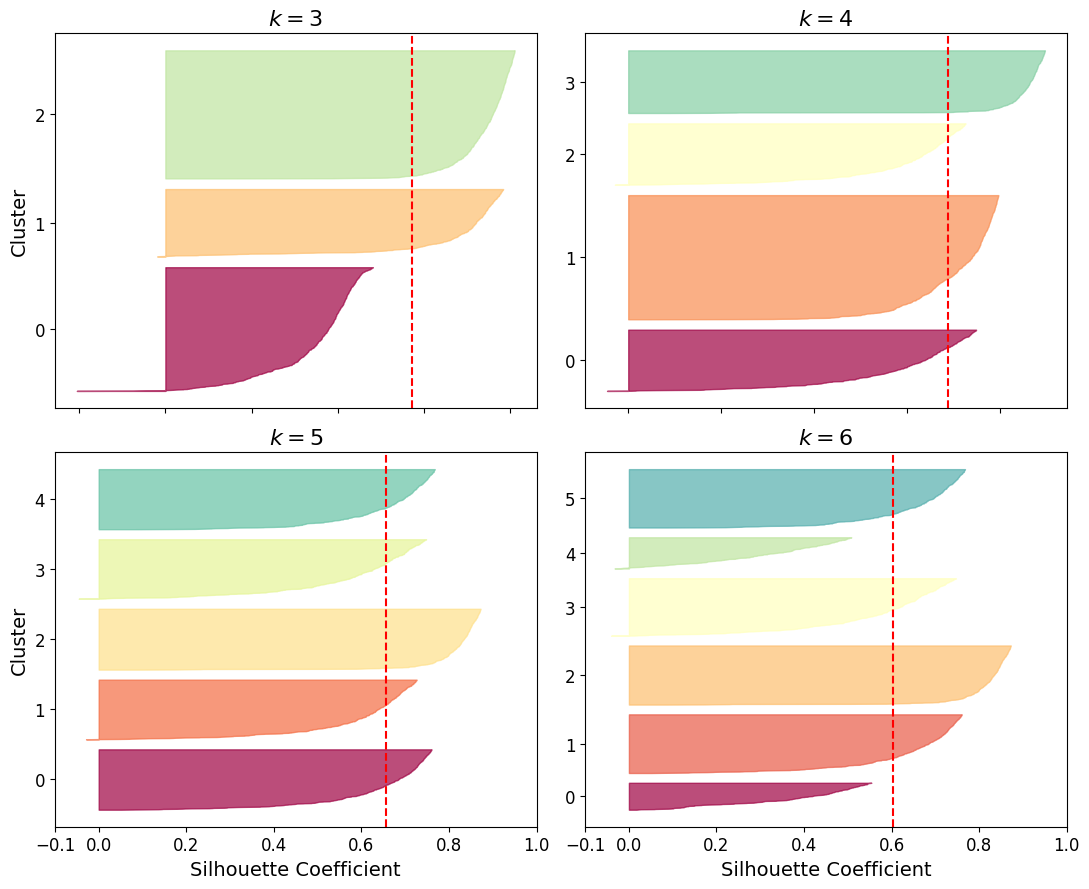

In [31]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

- 𝒌=3이나 𝒌=6은 나쁜 클러스터
  - 많은 샘플이 파선의 왼쪽에서 멈춰 있음
- 𝒌=4나 𝒌=5일때는 상당히 좋은 클러스터
  - 대부분의 샘플이 파선을 넘어서 뻗어 있고 1.0에 근접함
  - 𝒌=4일 때 인덱스 1의 클러스터가 매우 크며, 𝒌=5일 때는 모든 클러스터의 크기가 비슷함
- 𝒌=4일 때 전반적인 실루엣 점수가 𝒌=5보다 높더라도 **비슷한 크기의 클러스터를 얻을 수 있는 𝒌=5**를 선택

### **9.1.2 k-평균의 한계** 
k-평균은 속도가 빠르고 확장이 용이해 장점이 많지만 완벽한 것은 아님
- 최적이 아닌 솔루션을 피하려면 알고리즘을 여러 번 실행해야 함
- 클러스터 개수를 지정해야 하며, 이는 꽤 번거로운 작업임
- 클러스터의 크기나 밀집도가 서로 다르거나 원형이 아닐 경우 잘 작동하지 않음

#### **1) 크기와 밀접도, 방향이 다른 세 개의 타원형 클러스터를 가진 데이터셋 군집**

**1-1) 데이터셋 생성**

In [32]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [34]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

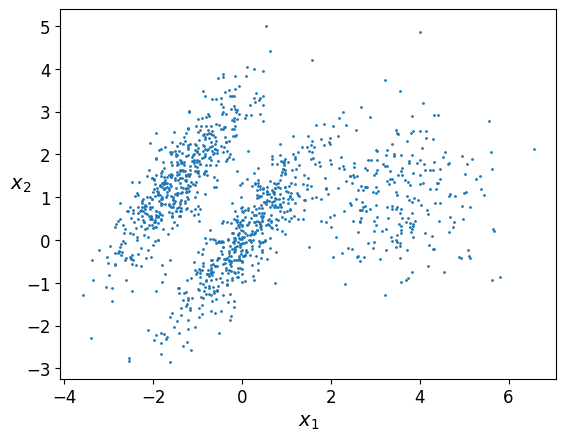

In [35]:
plot_clusters(X)

**1-2) k-평균 군집**

In [36]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

그림 저장: bad_kmeans_plot


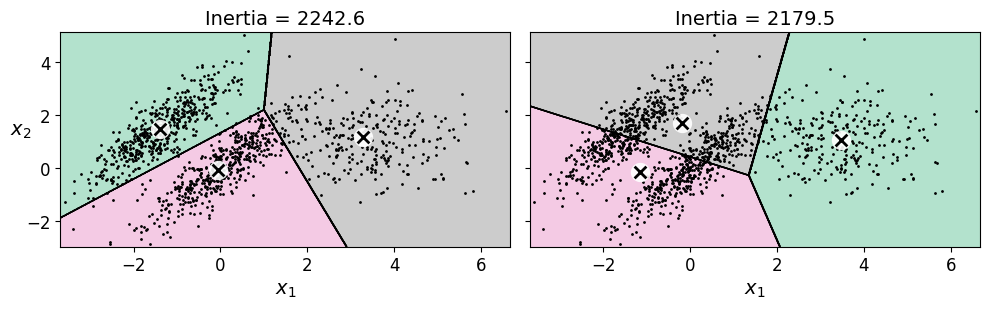

In [37]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

- 왼쪽 솔루션은 가운데 클러스터의 25% 정도가 오른쪽 클러스터로 할당 됨
- 오른쪽 솔루션은 이너셔가 더 작지만 끔찍한 수준

#### **2) k-평균의 한계 해결**
데이터에 따라 잘 수행할 수 있는 군집 알고리즘이 다름
- 타원형 클러스터에서는 가우시안 혼합 모델이 잘 작동함
- k-평균을 실행하기 전에 입력 특성의 스케일을 잘 맞추는 것도 중요

### **9.1.3 군집을 사용한 이미지 분할** 
이미지 분할은 이미지를 세그먼트 여러 개로 분할하는 작업
- 시맨틱 분할에서는 **동일한 종류의 물체에 속한 모든 픽셀은 같은 세그먼트에 할당** 됨
  - ex. 자율 주행 자동차의 비전 시스템에서 보행자 이미지를 구성하는 모든 픽셀은 '보행자' 세그멘트에 할당
  - 보행자는 다른 세그먼트가 될 수 있음
- 시맨틱 또는 인스턴스 분할에서 최고 수준의 성능을 내려면 합성곱 신경망 수준의 복잡한 모델 사용 필요

#### **1) 색상 분할** <br/>
동일한 색상을 가진 픽셀을 같은 세그먼트에 할당
- 합성곱 신경망 등보다 훨씬 쉬운 작업이며, 어떤 애플리케이션에서는 이 정도로 충분 함
- ex. 인공위성 사진을 분석하여 한 지역의 전체 산림 면적이 얼마나 되는지 측정

**1-1) 맷플롯립의 imread() 함수를 이용해 이미지 읽기**

In [39]:
import os
import urllib.request

In [40]:
# 무당벌레 이미지를 다운로드합니다
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x7f2a8b52feb0>)

In [41]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

**1-2) k-평균 사용** <br/>
배열을 RGB 색상의 긴 리스트로 변환한 다음 k-평균을 사용해 색상을 클러스터로 모음

In [42]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

**1-3) 원본 이미지 크기로 변경** <br/>
긴 색상의 리스트를 원본 이미지와 동일한 크기로 바꾸면 완성

In [43]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

그림 저장: image_segmentation_diagram


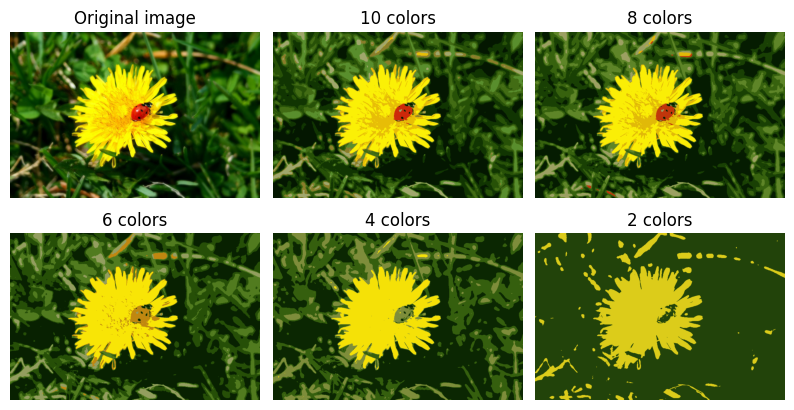

In [44]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

### **9.1.4 군집을 사용한 전처리**
군집은 차원 축소에 효과적인 방법이며, 지도 학습 알고리즘을 적용하기 전에 전처리 단계로 사용

#### **1) 차원 축소에 군집을 사용하는 예시**
0부터 9까지 숫자를 나타내는 8x8 크기 흑백 이미지 1,797개를 담은 숫자 데이터셋 사용

**1-1) 데이터셋 불러오기**

In [48]:
from sklearn.datasets import load_digits

In [49]:
X_digits, y_digits = load_digits(return_X_y=True)

**1-2) 훈련 세트와 테스트 세트로 분리**

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

**1-3) 로지스틱 회귀 모델 훈련**

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

**1-4) 테스트 세트에서 정확도 평가**

In [54]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

- 기준값 96.9%의 정확도

#### **2) k-평균을 전처리 단계로 사용**

**2-1) 분류 파이프라인 생성** <br/>
- 파이프라인을 만들어 훈련 세트를 50개의 클러스터로 모음
- 이미지를 50개 클러스터까지 거리로 바꿈
- 로지스틱 회귀 모델을 적용

In [56]:
from sklearn.pipeline import Pipeline

In [57]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

**2-2) 분류 파이프 라인 평가** <br/>
약 30%까지 오차율을 줄임

In [58]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

**2-3) 최적의 클러스터 개수 찾기** <br/>
가장 좋은 K값은 교차 검증에서 가장 좋은 분류 성능을 내는 값
- GridSerachCV 사용

In [59]:
# from sklearn.model_selection import GridSearchCV

# param_grid = dict(kmeans__n_clusters=range(2, 100))
# grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
# grid_clf.fit(X_train, y_train)

**2-4) 최선의 k값과 파이프라인의 성능 확인**

In [60]:
# grid_clf.best_params_
# grid_clf.score(X_test, y_test)

- k=99개의 클러스터를 사용할 때 정확도가 크게 향상

### **9.1.5 군집을 사용한 준지도 학습** 
레이블이 없는 데이터가 많고 레이블이 있는 데이터는 적을 때 사용

#### **1) 준지도 학습 예시**

**1-1) 로지스틱 회귀 모델 훈련** <br/>
숫자 데이터셋에서 레이블된 50개의 샘플에 훈련

In [62]:
n_labeled = 50

**1-2) 테스트 세트 모델 성능 확인** <br/>

In [63]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

#### **2) 대표 이미지로 개선**
훈련 세트를 50개의 클러스터로 모으고 센트로이드에 가장 가까운 이미지

**2-1) 대표 이미지 확인** <br/>

In [64]:
k = 50

In [65]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

그림 저장: representative_images_diagram


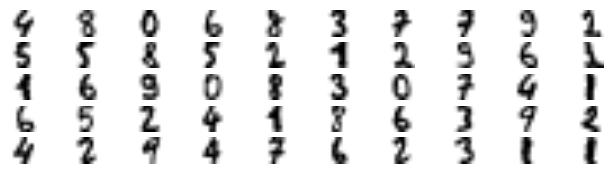

In [66]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

**2-2) 수동 레이블 할당**

In [67]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 1, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

- 50개의 샘플로 이루어진 데이트셋 준비

**2-3) 성능 확인**

In [68]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.09555555555555556

#### **3) 레이블 전파**
동일한 클러스터에 있는 모든 샘플로 레이블 전파

**3-1) 레이블 전파 적용**

In [70]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

**3-2) 모델 훈련 및 성능 확인**

In [71]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [72]:
log_reg.score(X_test, y_test)


0.15333333333333332

- 각 대표 샘플의 레이블을 동일한 클러스터의 모든 샘플에 전파
- 클러스터 경계에 가깝게 위치한 샘플이 포함되어 있어 잘못 레이블이 부여됨

**3-3) 가까운 샘플 20%에만 레이블 전파**

In [73]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [74]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

**3-4) 다시 훈련**

In [75]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [76]:
log_reg.score(X_test, y_test)

0.15777777777777777

- 94.0%의 정확도를 얻음
- 전파된 레이블이 실제로 매우 좋아 성능이 좋게 나옴

#### **4) 능동 학습**
모델과 훈련 세트를 지속적으로 향상하기 위해 능동학습을 몇 번 반복할 수 있음
- 전문가가 학습 알고리즘과 상호작용하여 알고리즘이 요청할 때 특정 샘플의 레이블 제공
- 여러 전략이 사용되지만, 가장 많이 사용되는 것은 불확실성 샘플링

**4-1) 불확실성 샘플링 작동 방식** <br/>
- 지금까지 수집한 레이블된 샘플에서 모델을 훈련하며, 이를 사용해 레이블되지 않은 모든 샘플에 대한 예측 생성
- 모델이 가장 불확실하게 예측한 샘플을 전문가에게 보내 레이블을 붙임
- 레이블을 부여하는 노력만큼 성능이 향상되지 않을 때까지 반복

**4-2) 다른 전략** <br/>
모델을 가장 크게 바꾸는 샘플이나 모델의 검증 점수를 크게 떨어트리는 샘플, <br/> 여러 개의 모델이 동일한 예측을 내지 않는 샘플에 대해 레이블을 요청하는 것

### **9.1.6 DBSCAN**
밀집된 연속적 지역을 클러스터로 정의하며, 인기가 높은 군집 알고리즘

#### **1) 작동 방식**
- 알고리즘이 각 샘플에서 입실론 내 샘플이 몇개 놓여 있는지 셈
- e-이웃 내에 적어도 min_samples 개 샘플이 있따면 이를 핵심 샘플로 간주
- 핵심 샘플의 이웃에 있는 모든 샘플은 동일한 클러스터에 속함
- 핵심 샘플도 아니고 이웃도 아닌 샘플은 이상치로 판단

#### **2) DBSCAN 클래스**

**2-1) DBSCAN 테스트** <Br/>
반달 모양 데이터셋 사용

In [79]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [80]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

**2-2) lables_** <br/>
모든 샘플의 레이블 저장
- 일부 샘플의 클러스터 인덱스는 -1
- 알고리즘이 샘플을 이상치로 판단했다는 의미

In [81]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

**2-3) 핵심 샘플 인덱스** <br/>
core_sample_indices_에서 확인할 수 있음
- 핵심 샘플 자체는 인스턴트 변수 components_에 저장

In [82]:
len(dbscan.core_sample_indices_)

808

In [83]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [84]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

**2-4) 두 가지 다른 이웃 반경을 사용한 DBSCAN 군집**

In [88]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [89]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

그림 저장: dbscan_plot


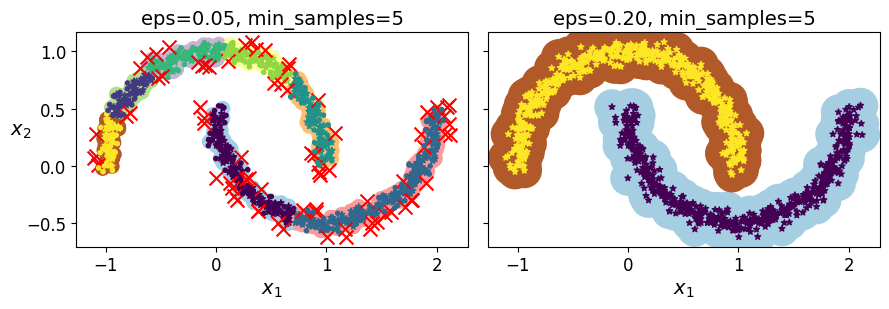

In [90]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()

- 왼쪽은 클러스터를 7개로 만들었고 많은 샘플을 이상치로 판단
- 오른쪽은 eps를 0.2로 증가해 샘플의 이웃 범위를 넓혀 완벽한 군집을 얻음

#### **3) fit_predict() 메서드**
predict() 메서드를 제공하지 않고 fit_predict() 메서드 제공
- 새로운 샘플에 대해 클러스터를 예측할 수 없음
- 구현 결정은 다른 분류 알고리즘이 더 잘 수행하기 때문
- 사용자가 필요한 예측기를 선택해야 함

**3-1) KNeighborClassifier 훈련**

In [91]:
dbscan = dbscan2

In [94]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

**3-2) 클러스터 확률 추정** <br/>
샘플 몇개 추정 후 어떤 클러스터에 속할 가능성이 높은지 예측
- 모든 샘플에서 훈련도 가능

In [95]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [96]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

**3-3) 결정 경계 확인**

그림 저장: cluster_classification_plot


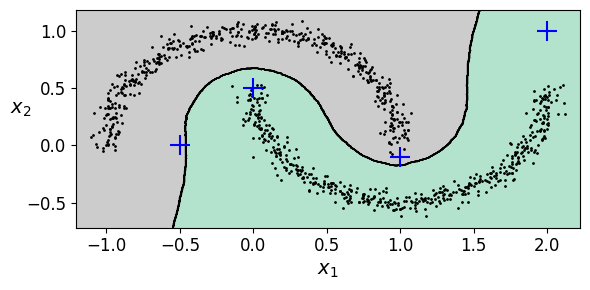

In [97]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

**3-4) 이상치 분류** <br/>
최대 거리를 사용하면 두 클러스터에서 멀리 떨어진 샘플을 이상치로 간단히 분류 가능
- KNeighborsClassifier의 kneighbors() 메서드 사용

In [98]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

### **9.1.7 다른 군집 알고리즘**
- 병합 군집
- BIRCH
- 평균-이동
- 유사도 전파
- 스펙트럼 군집

## **9.2 가우시안 혼합**

#### **1) 가우시안 혼합 모델 (GMM)**
샘플이 파라미터가 알려지지 않은 여러 개의 혼합된 가우시안 분포에서 생성되었다고 가정하는 확률 모델
- 하나의 가우시안 분포에서 생성된 모든 샘플은 하나의 클러스터 형성
- 일반적으로 형성되는 클러스터는 타원형
  - 각 클러스터의 모양, 크기, 밀집도, 방향이 다름
  - 샘플이 주어지면 가우시안 분포 중 하나에서 생성되었다는 것을 알지만 파라미터는 알지 못함

**1-1) GMM 변종** <br/>
가장 간단한 버전이 GaussianMixture 클래스에 구현됨
- 사전에 가우시안 분포의 개수 k개를 알아야 함
- 데이터셋 X가 다음 확률 과정을 통해 생성되었다고 가정
  - 샘플마다 k개의 클러스터에서 랜덤하게 한 클러스터 선택
  - 가우시안 분포에서 랜덤하게 샘플링됨
  - 생성과정은 그래프 모형으로 나타낼 수 있음

**1-2) 그래프 모형** <br/>
확률 변수 사이의 조건부 의존성의 구조를 나타냄
- 원은 확률 변수를 나타냄
- 사각형은 고정값, 즉 모델의 파라미터를 나타냄
- 큰 사각형은 플레이트로, 이 사각형 안의 내용이 여러 번 반복된다는 것을 나타냄
  - 오른쪽 아래 숫자는 플레이트 내용이 얼마나 반복되는 지를 표시
  - m개의 확률변수 z와 m개의 확률 변수 x가 존재
- 각 변수는 가중치 𝟇를 갖는 범주형 분포에서 샘플링
- 실선 화살표는 조건부 의존성을 표현
- 구불구불한 화살표는 스위치를 나타냄
- 색이 채워진 원은 알려진 값이라는 의미로, 이를 관측 변수라고 함
  - 알려지지 않은 확률 변수는 잠재 변수라고 부름

#### **2) GaussianMixture 클래스 사용**

**2-1) 알고리즘으로 추정**

In [99]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [100]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

**2-2) 추정한 파라미터 확인**

In [101]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [102]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [103]:

gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

#### **3) 기댓값-최대화 알고리즘**
k-평균 알고리즘과 공통점이 많은 알고리즘
- 기댓값 단계: 샘플을 클러스터에 할당
  - 현재 클러스터 파라미터에 기반해 각 클러스터에 속할 확률 예측
- 최대화 단계: 클러스터를 업데이트
  - 각 클러스터가 데이터셋에 있는 모든 샘플을 사용해 업데이트
- 클러스터에 속할 추정 확률로 샘플에 가중치 적용
  - 이 확률을 샘플에 대한 클러스터의 책임이라 부름
  - 최대화 단계에서 클러스터 업데이트는 책임이 가장 많은 샘플에 크게 영향

**3-1) 알고리즘 수렴 여부 및 반복 횟수 확인**

In [104]:
gm.converged_

True

In [105]:
gm.n_iter_

4

**3-2) 클러스터에 속할 확률 예측**
- 하드군집은 predict(), 소프트군집은 predict_proba() 메서드 사용

In [106]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2])

In [107]:
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

**3-4) 새로운 샘플 생성** <br/>
가우시안 혼합 모델은 생성 모델로, 새로운 샘플을 만들 수 있음

In [108]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [109]:
y_new

array([0, 0, 1, 2, 2, 2])

**3-5) 모델의 밀도 추정** <br/>
샘플이 주어지면 그 위치의 확률 밀도 함수의 로그를 예측

In [110]:
gm.score_samples(X)

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

In [111]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999215022

**3-6) 훈련된 가우시안 혼합 모델의 클러스터 평균, 결정 경계, 밀도 등고선**

In [112]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

그림 저장: gaussian_mixtures_plot


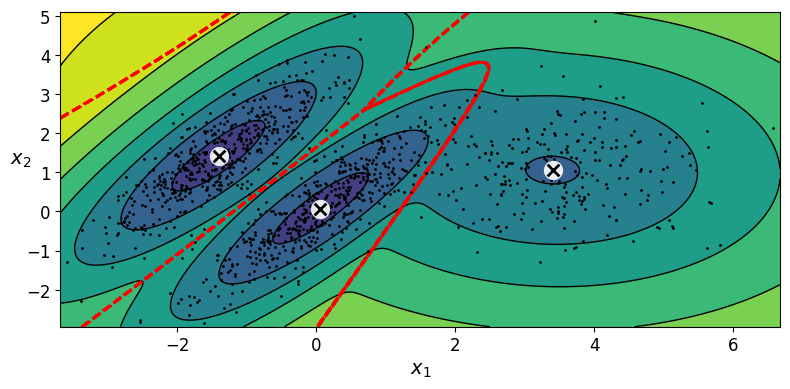

In [113]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

#### **4) 학습할 파라미터 개수 제한** <br/>
특성이나 클러스터가 많거나 샘플이 적은 경우 EM이 최적의 솔루션으로 수렴하기 어려움
- 알고리즘이 학습할 파라미터 개수 제한
- 클러스터의 모양과 방향의 범위 제한
- covaraince_type 매개변수에서 선택
  - spherical: 모든 클러스터가 원형이지만 지름이 다를 수 있음
  - diag: 클러스터는 크기에 상관없이 어던 타원형이든 가능
  - tied: 모든 클러스터가 동일한 타원 모양, 크기, 방향을 가짐
  - 기본값은 full

In [114]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [117]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

그림 저장: covariance_type_plot


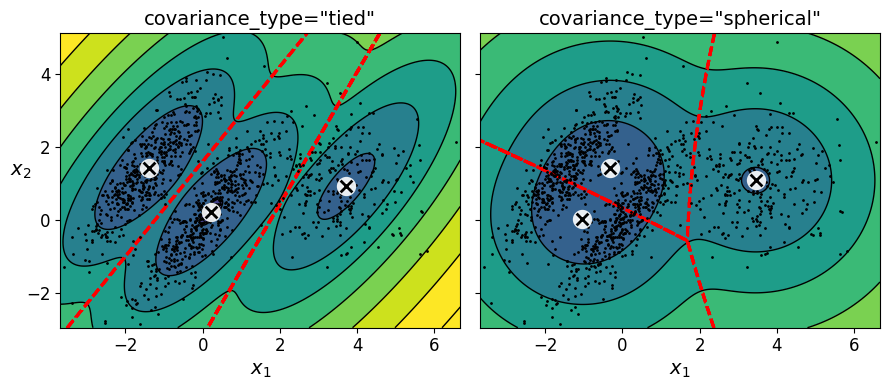

In [118]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

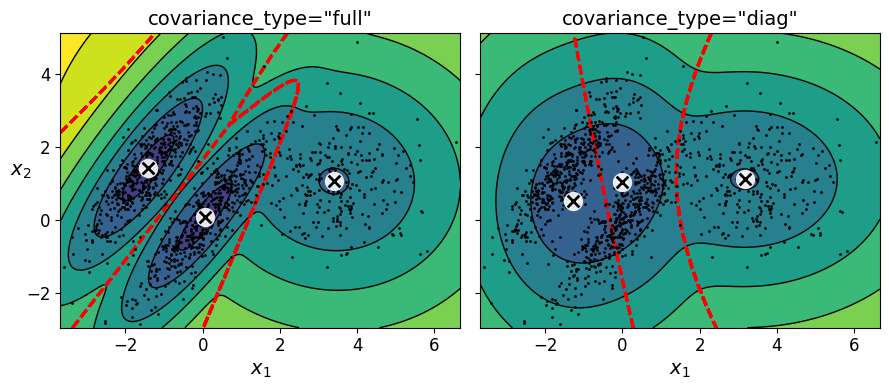

In [119]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

### **9.2.1 가우시안 혼합을 사용한 이상치 탐지**
이상치 탐지는 보통과 많이 다른 샘플을 감지하는 작업
- 부정 거래 감지, 제조 결함 제품 감지 등 다양한 애플리케이션에서 사용할 수 있음
- 모델 훈련 전 데이터셋에서 이상치 제거 시 사용

#### **1) 가우시안 혼합 모델을 이상치 탐지에 사용** 
밀도가 낮은 지역에 있는 모든 샘플을 이상치로 감지
- 밀도 임곗값을 정해야 하며, 정밀도/재현율 트레이드오프가 적용됨

In [120]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

그림 저장: mixture_anomaly_detection_plot


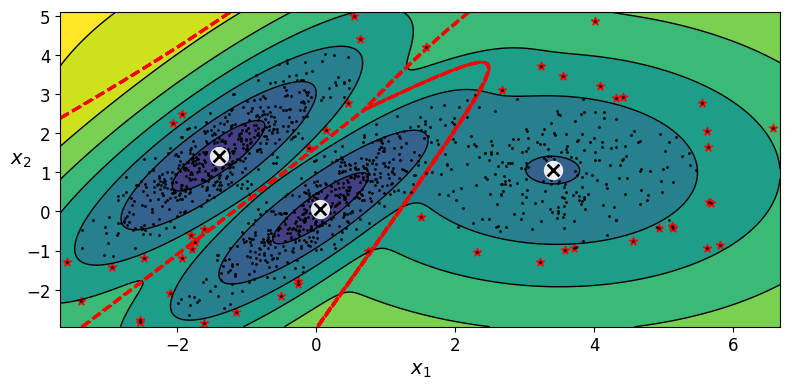

In [121]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

#### **2) 특이치 감지**
이상치로 오염되지 않은 깨끗한 데이터셋에서 훈련하며, 데이터셋을 정제하는데 자주 사용

### **9.2.2 클러스터 개수 선택** 
가우시안 혼합에서는 이너셔나 실루엣 점수를 사용할 수 없음
- 정의된 BIC나 AIC와 같은 이론적 정보 기준을 최소화하는 모델을 찾음
- BIC와 AIC 모두 모델이 많은 파라미터(예를 들면 많은 클러스터)를 학습하지 못하도록 제한

In [122]:
gm.bic(X)

8189.747000497186

In [123]:
gm.aic(X)

8102.521720382148

#### **9.2.3 베이즈 가우시안 혼합 모델**
최적의 클러스터 개수를 수동으로 찾는 대신 BayesianGaussianMixture 클래스를 사용
- 불필요한 클러스터의 가중치를 0으로 (또는 0에 가깝게) 만들 수 있음
- 최적의 클러스터 개수보다 큰 컴포넌트의 개수를 지정
- 자동으로 불필요한 클러스터를 제거

In [124]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

- 알고리즘이 자동으로 3개의 컴포넌트가 필요하다는 것을 감지

In [125]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

#### **1) 베타 분포** 
이 모델에서 클러스터 파라미터는 더는 고정된 모델 파라미터가 아니라 잠재 확률 변수
- 고정 범위 안에 놓은 값을 가진 확률 변수를 모델링할 때 사용됨
- 잠재 변수 z에 대한 사전 지식이 사전 확률에 의해 인코딩 될 수 있음

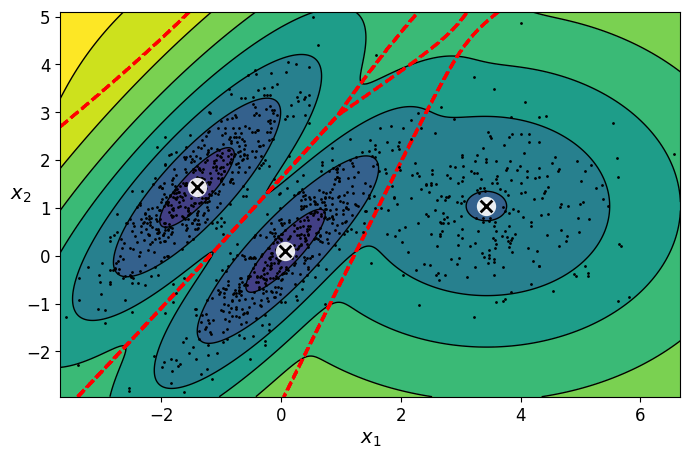

In [126]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

**1-1) 사후 확률 분포 계산** <br/>
데이터 X를 관측하고 난 후 잠재 변수에 대한 확률 분포를 업데이트하는 방법 설명

**1-2) 증거 p(x)** <br/>
가능한 모든 z값에 대해 적분해야 하므로 가우시안 혼합 모델에서는 계산하기 어려움
- 모든 클러스터 파라미터와 클러스터 할당의 조합을 고려해야 함

**1-3) 변분 추론** <br/>
변분 파라미터를 가진 분포 패밀리를 선택한 후 파라미터를 최적화
- 최소화하는 람다를 찾아 이를 해결
- KL 발산 공식에 나타나있으며, 이를 최소화하려면 증거 하한(ELBO) 최대화

**1-4) 평균장 변분 추론** <br/>
ELBO 식을 계산할 수 있는 형태로 단순화하기 위해 분포 패밀리와 사전 확률을 매우 주의 깊게 선택
- 수학적 기술이 필요하며, BayesianGaussainMixture 클래스 활용

**1-4) 블랙 박스 확률적 변분 추론** <Br/>
ELBO를 최대화하는 간단한 방법
- 각 반복에서 몇 개의 샘플을 q에서 뽑아 변분 파라미터 람다에 대한 ELBO 그레이디언트를 추정
- 그 다음 경사 상승법 스텝에서 사용하며, 어떤 종류의 모델과도 베이즈 추론을 사용할 수 있게 함

#### **2) 타원형이 아닌 클러스터에 가우시안 혼합 모델을 훈련하기**  <br/>
가우시안 혼합 모델을 타원형 클러스터에는 잘 작동하지만, 다른 모양을 가진 데이터셋을 훈련하면 나쁜 결과를 얻음

**2-1) 반달 데이터셋을 군집하기 위해 베이즈 가우시안 혼합 모델 사용**

In [127]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [128]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [129]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

그림 저장: mixture_concentration_prior_plot


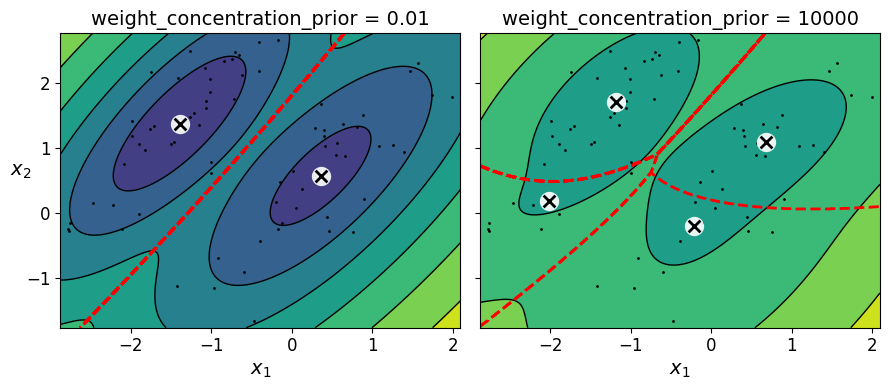

In [130]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()

In [131]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [132]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

그림 저장: moons_vs_bgm_plot


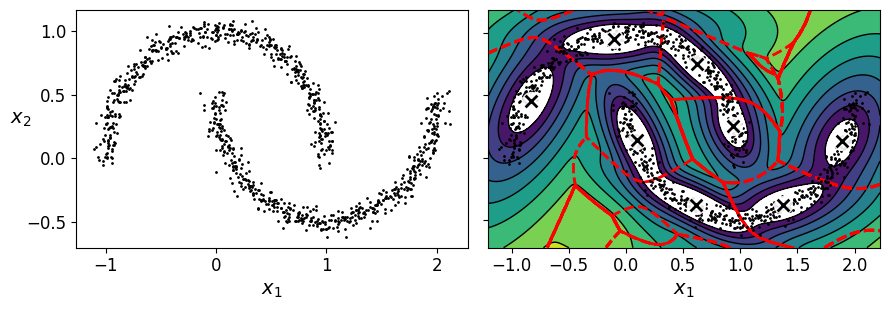

In [133]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

- 필사적으로 타원을 찾으므로 2개가 아닌 8개의 클러스터를 찾음
- 밀도 추정은 나쁘지 않으므로 이상치 감지를 위해서는 사용 가능

### **9.2.4 이상치 탐지와 특이치 탐지를 위한 다른 알고리즘**
이상치 탐지와 특이치 탐지 전용으로 사용할 수 있는 몇 가지 알고리즘 구현
- PCA: 간단하고 종종 매우 효과적인 이상치 탐지 기법
- Fast-MCD: 이상치 감지에 유용하며, 데이터셋 정제 시 사용
  - 샘플이 하나의 가우시안 분포에서 생성되었다고 가정
  - 가우시안 분포에서 생섣되지 않은 이상치로 데이터셋이 오염되었다고 가정
- 아이솔레이션 포레스트: 고차원 데이터셋에서 이상치 감지를 위한 효율적인 알고리즘
  - 무작위로 성장한 결정 트리로 구성된 랜덤 포레스트를 만듦
  - 각 노드에서 특성을 랜덤하게 선택한 뒤 랜덤한 임곗값을 골라 데이터셋을 분리
  - 이상치는 일반적으로 다른 샘플과 멀리 떨어져있으므로 평균적으로 격리 됨
- LOF: 이상치 탐지에 좋음
  - 주어진 샘플 주위의 밀도와 이웃 주위의 밀도를 비교
  - 이상치는 종종 k개의 최근접 이웃보다 더 격리됨
- one-class SVM: 특이치 참지에 잘맞음
  - 고차원 공간에 모든 샘플을 매핑한 다음 고차원 공간에서 선형 SVM 분류기를 사용해 두 클래스 분리
  - SVM 알고리즘이 원본 공간으로부터 고차원 공간에 있는 샘플 분리
  - 원본 공간에서는 모든 샘플을 둘러싼 작은 영역을 찾는 것에 해당
  - 새로운 샘플이 이 영역에 놓이지 않으면 이는 이상치